# Nan Checking
*Remaining NaN Feature*

SMILES parsing failed: 0 molecules


 33%|███▎      | 556/1681 [00:03<00:05, 214.69it/s]

c:\Users\sbjan\miniconda3\envs\isomeric_env\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 80%|████████  | 1353/1681 [00:07<00:01, 237.81it/s]

c:\Users\sbjan\miniconda3\envs\isomeric_env\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1681/1681 [00:09<00:00, 183.19it/s]
C:\Users\sbjan\AppData\Local\Temp\ipykernel_22000\827099282.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc_df = desc_df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))


Columns with NaN values and their NaN ratios:
ABC          1.000000
MINsssPbH    1.000000
MINssssSi    1.000000
MINsssSiH    1.000000
MINssSiH2    1.000000
               ...   
GATS7se      0.001190
MATS7dv      0.001190
GATS7m       0.001190
MATS7Z       0.001190
MDEC-23      0.000595
Length: 546, dtype: float64


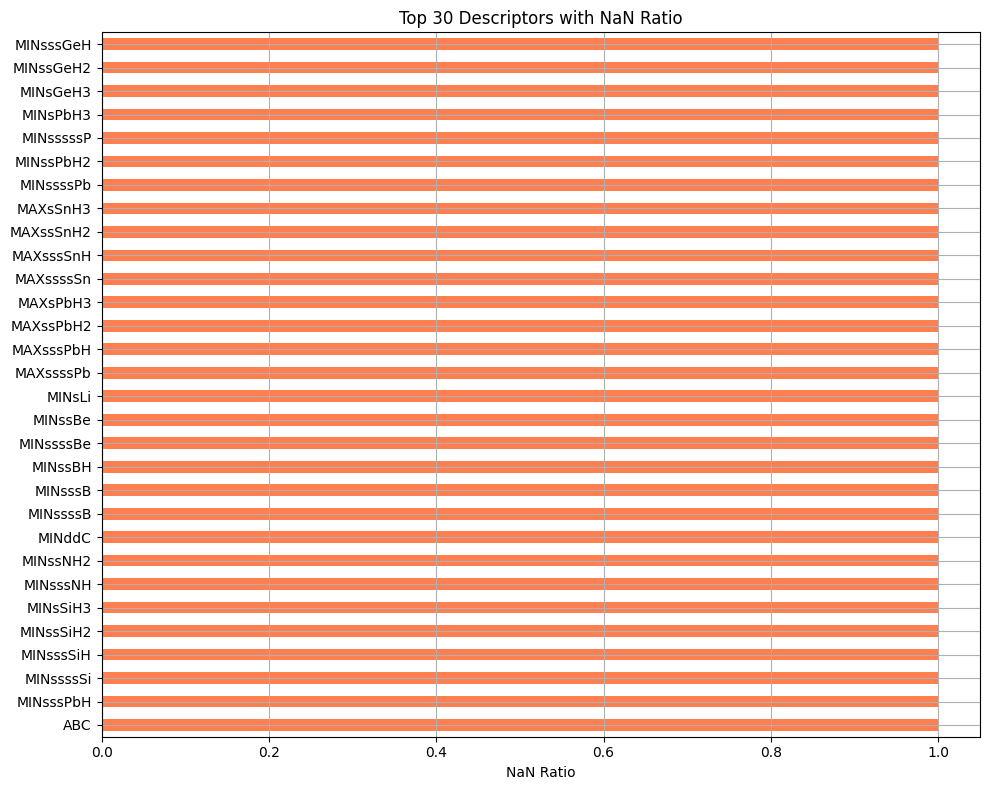

Total Mordred features: 1613
Used features (NaN <= 20%): 1427
Feature usage rate: 88.47%
All done. Output saved to 'processed_descriptors_filtered.csv'


In [7]:
import pandas as pd
import numpy as np
from rdkit import Chem
from mordred import Calculator, descriptors
import matplotlib.pyplot as plt

# 1. Load CSV
df = pd.read_csv("data/train_isomeric.csv")
df = df.dropna(subset=["Isomeric_Smiles"])

# 2. Setup Mordred calculator
calc = Calculator(descriptors, ignore_3D=True)

# 3. Convert SMILES to Mol
mols = []
fail_idx = []
for i, smi in enumerate(df["Isomeric_Smiles"]):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        fail_idx.append(i)
    mols.append(mol)

print(f"SMILES parsing failed: {len(fail_idx)} molecules")

# 4. Compute descriptors
desc_df = calc.pandas(mols)

# 5. 문자열 포함 셀 → 숫자 변환 시도, 실패 시 NaN으로 변환
desc_df = desc_df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))

# 6. NaN 비율 계산
nan_ratio = desc_df.isna().mean()
nan_ratio = nan_ratio[nan_ratio > 0]

print("Columns with NaN values and their NaN ratios:")
print(nan_ratio.sort_values(ascending=False))

# 7. NaN 비율 시각화 (Top 30)
if not nan_ratio.empty:
    plt.figure(figsize=(10, 8))
    nan_ratio.sort_values(ascending=False).head(30).plot(kind="barh", color="coral")
    plt.xlabel("NaN Ratio")
    plt.title("Top 30 Descriptors with NaN Ratio")
    plt.tight_layout()
    plt.grid(True)
    plt.savefig("top_nan_descriptors.png")
    plt.show()

# 8. 실패한 SMILES 인덱스 제거 및 인덱스 재정렬
desc_df = desc_df.drop(index=fail_idx).reset_index(drop=True)
df_clean = df.drop(index=fail_idx).reset_index(drop=True)

# 9. NaN 비율 20% 초과하는 컬럼 제거
threshold = 0.2
valid_columns = desc_df.columns[desc_df.isna().mean() <= threshold]
desc_df_filtered = desc_df[valid_columns]

# 10. 사용 가능한 피처 비율 계산
total_features = desc_df.shape[1]
used_features = desc_df_filtered.shape[1]
used_ratio = used_features / total_features * 100

print(f"Total Mordred features: {total_features}")
print(f"Used features (NaN <= 20%): {used_features}")
print(f"Feature usage rate: {used_ratio:.2f}%")

# 11. 원본 데이터와 필터링된 descriptor 결합
final_df = pd.concat([df_clean, desc_df_filtered], axis=1)

# 12. 결과 저장
final_df.to_csv("processed_descriptors_filtered.csv", index=False)
print("All done. Output saved to 'processed_descriptors_filtered.csv'")

